# Import packages

In [ ]:
# -*- coding- utf-8 -*-

In [ ]:
from tqdm import tqdm
from collections import Counter
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import confusion_matrix,cohen_kappa_score, mean_squared_error, f1_score
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import json
import pandas as pd
import numpy as np
import warnings
import random
import time
import os
import matplotlib.pyplot as plt
import multiprocessing
import seaborn as sns
from multiprocessing import Lock, Process, Queue, current_process
import scipy as sp
from functools import partial
from numba import jit
from sklearn.preprocessing import OneHotEncoder
import gc
pd.set_option('display.max_columns', 1000)
warnings.filterwarnings('ignore')

# Remove Drift

ref:https://www.kaggle.com/cdeotte/data-without-drift

In [3]:
DATA_PATH = ""#"../input/data-without-drift"

train = pd.read_csv(os.path.join(DATA_PATH, 'train_clean.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test_clean.csv'))

DATA_PATH2 = ""#"../input/liverpool-ion-switching"
submission_df = pd.read_csv(os.path.join(DATA_PATH2, 'sample_submission.csv'))

RFC_DATA_PATH =""# '/kaggle/input/ion-shifted-rfc-proba'
#y_train_proba = np.load(f"{RFC_DATA_PATH}/Y_train_proba.npy")
#y_test_proba = np.load(f"{RFC_DATA_PATH}/Y_test_proba.npy")
y_train_proba = np.load("Y_train_proba.npy")
y_test_proba = np.load("Y_test_proba.npy")

# Clean Batch 7

Ref:https://www.kaggle.com/fkubota/clean-batch7-signal

In [4]:
def group_feat_train(_train):
    train = _train.copy()
    # group init
    train['group'] = int(0)

    # group 1
    idxs = (train['batch'] == 3) | (train['batch'] == 7)
    train['group'][idxs] = int(1)

    # group 2
    idxs = (train['batch'] == 5) | (train['batch'] == 8)
    train['group'][idxs] = int(2)

    # group 3
    idxs = (train['batch'] == 2) | (train['batch'] == 6)
    train['group'][idxs] = int(3)

    # group 4
    idxs = (train['batch'] == 4) | (train['batch'] == 9)
    train['group'][idxs] = int(4)
    
    return train[['group']]

In [5]:
batch_list = []
for n in range(10):
    batchs = np.ones(500000)*n
    batch_list.append(batchs.astype(int))
batch_list = np.hstack(batch_list)
train['batch'] = batch_list

In [6]:
group = group_feat_train(train)
train = pd.concat([train, group], axis=1)

In [7]:
def create_signal_mod(train):
    left = 3641000
    right = 3829000
    thresh_dict = {
        3: [0.1, 2.0],
        2: [-1.1, 0.7],
        1: [-2.3, -0.6],
        0: [-3.8, -2],
    }
    
    train['signal_mod'] = train['signal'].values
    for ch in train[train['batch']==7]['open_channels'].unique():
        idxs_noisy = (train['open_channels']==ch) & (left<train.index) & (train.index<right)
        idxs_not_noisy = (train['open_channels']==ch) & ~idxs_noisy
        mean = train[idxs_not_noisy]['signal'].mean()

        idxs_outlier = idxs_noisy & (thresh_dict[ch][1]<train['signal'].values)
        train['signal_mod'][idxs_outlier]  = mean
        idxs_outlier = idxs_noisy & (train['signal'].values<thresh_dict[ch][0])
        train['signal_mod'][idxs_outlier]  = mean
    return train
train = create_signal_mod(train)

Text(0, 0.5, 'signal')

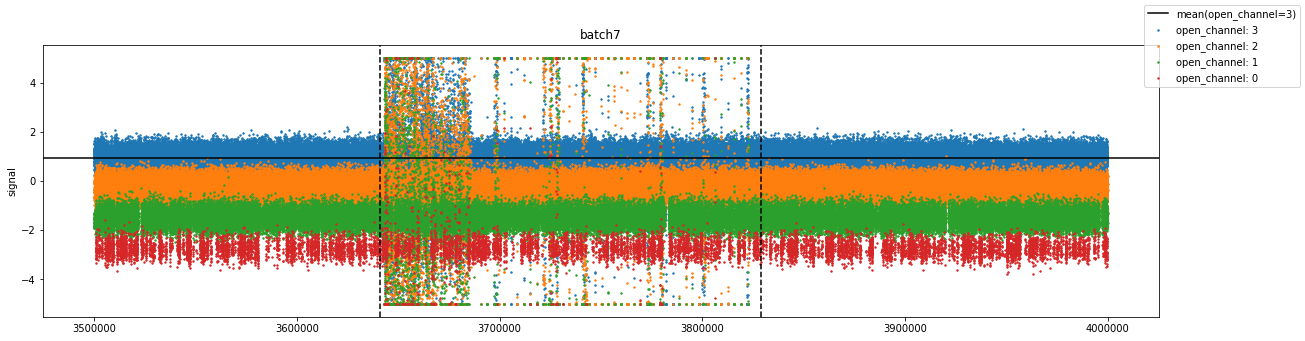

In [9]:
#Before replace outlier
res = 100
x = np.arange(len(train))

left = 3641000
right = 3829000

fig = plt.figure(figsize=(20, 5))
for i in train[train['batch']==7]['open_channels'].unique():
    idxs = (train['batch'] == 7) & (train['open_channels'].values==i)
    plt.scatter(x[idxs], train['signal'].values[idxs], s=2, label=f'open_channel: {i}')
plt.axvline(left, linestyle='--', color='black')
plt.axvline(right, linestyle='--', color='black')

# batch7 signal mean (without noisy area)
idxs_noisy = (train['open_channels']==3) & (left<train.index) & (train.index<right)
idxs_not_noisy = (train['open_channels']==3) & ~idxs_noisy
plt.axhline(train[idxs_not_noisy]['signal'].mean(), label='mean(open_channel=3)', color='black')
    
fig.legend(fontsize=10)
plt.title('batch7')
plt.ylabel('signal')

Text(0, 0.5, 'signal')

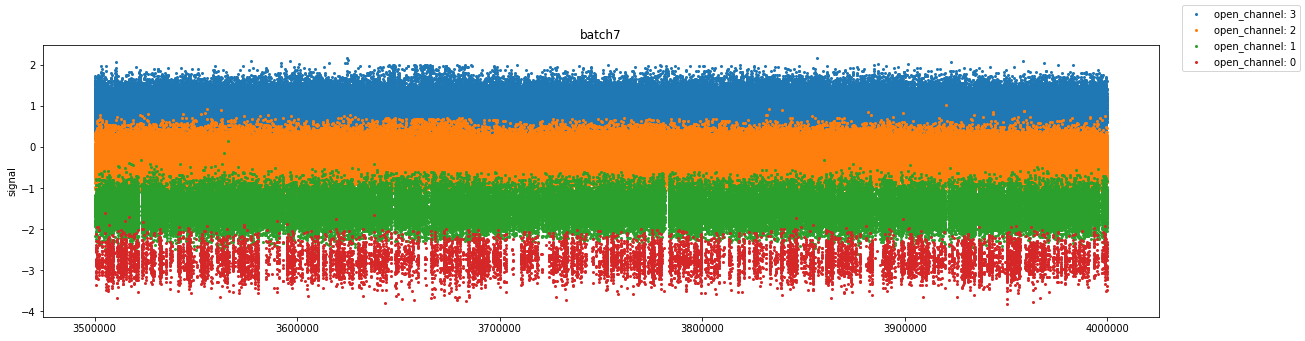

In [11]:
#After replace outlier
res = 100
x = np.arange(len(train))

fig = plt.figure(figsize=(20, 5))
for i in train[train['batch']==7]['open_channels'].unique():
# for i in [0]:
    idxs = (train['batch'] == 7) & (train['open_channels'].values==i)
    plt.scatter(x[idxs], train['signal_mod'].values[idxs], s=4, label=f'open_channel: {i}')
    
    
fig.legend(fontsize=10)
plt.title('batch7')
plt.ylabel('signal')

In [10]:
train.head()

,time,signal,open_channels,batch,group,signal_mod
0,0.0001,-2.7600,0,0,0,-2.7600
1,0.0002,-2.8557,0,0,0,-2.8557
2,0.0003,-2.4074,0,0,0,-2.4074
3,0.0004,-3.1404,0,0,0,-3.1404
4,0.0005,-3.1525,0,0,0,-3.1525


In [12]:
train=train.drop(["group","batch","signal"],axis=1)
train = train.rename(columns={"signal_mod":"signal"})
train.head()

,time,open_channels,signal
0,0.0001,0,-2.7600
1,0.0002,0,-2.8557
2,0.0003,0,-2.4074
3,0.0004,0,-3.1404
4,0.0005,0,-3.1525


# Feature Engineering

In [14]:
from tqdm import tqdm_notebook
for batch_size in tqdm_notebook([10000, 25000, 50000]):
    train['batch'] = ((train['time'] * 10000) - 1) // batch_size
    train['batch_index'] = ((train['time'] * 10000) - 1)  - (train['batch'] * batch_size) #10_000 is same as 10000.
    train['batch_slices'] = train['batch_index']  // (batch_size / 10)
    train['batch_slices2'] = train['batch'].astype(str).str.zfill(3) + '_' + train['batch_slices'].astype(str).str.zfill(3) #zfill() is zero patting function
    
    for agg_feature in ['batch', 'batch_slices2']:
        train[f"min_{agg_feature}_{batch_size}"] = train.groupby(agg_feature)['signal'].transform('min')
        train[f"max_{agg_feature}_{batch_size}"] = train.groupby(agg_feature)['signal'].transform('max')
        train[f"std_{agg_feature}_{batch_size}"] = train.groupby(agg_feature)['signal'].transform('std')
        train[f"mean_{agg_feature}_{batch_size}"] = train.groupby(agg_feature)['signal'].transform('mean')
        
        train[f"min_{agg_feature}_{batch_size}_diff"] = train[f"min_{agg_feature}_{batch_size}"] - train['signal']
        train[f"max_{agg_feature}_{batch_size}_diff"] = train[f"max_{agg_feature}_{batch_size}"] - train['signal']
        train[f"std_{agg_feature}_{batch_size}_diff"] = train[f"std_{agg_feature}_{batch_size}"] - train['signal']
        train[f"mean_{agg_feature}_{batch_size}_diff"] = train[f"mean_{agg_feature}_{batch_size}"] - train['signal']


    #Commit1 & 2 result imply that small window contain important information
    window_sizes = [5, 10,100]#100, 500,5, 25, 50,, 5000, 10000 25000, 30000]
    for window in window_sizes:
        train["rolling_maen_" + str(window) + '_batch_' + str(batch_size)] = train.groupby('batch')['signal'].rolling(window=window).mean().reset_index()['signal']
        train["rolling_std_" + str(window) + '_batch_' + str(batch_size)] = train.groupby('batch')['signal'].rolling(window=window).std().reset_index()['signal']
        #train["rolling_var_" + str(window) + '_batch_' + str(batch_size)] = train.groupby('batch')['signal'].rolling(window=window).var().reset_index()['signal']
        train["rolling_min_" + str(window) + '_batch_' + str(batch_size)] = train.groupby('batch')['signal'].rolling(window=window).min().reset_index()['signal']
        train["rolling_max_" + str(window) + '_batch_' + str(batch_size)] = train.groupby('batch')['signal'].rolling(window=window).max().reset_index()['signal']

        train["rolling_std_" + str(window) + '_batch_' + str(batch_size)+'_diff'] = train.groupby('batch')['signal'].rolling(window=window).std().reset_index()['signal'] - train['signal'] #add
        train["rolling_mean_" + str(window) + '_batch_' + str(batch_size)+'_diff'] = train.groupby('batch')['signal'].rolling(window=window).mean().reset_index()['signal'] - train['signal'] #add
        train["rolling_max_" + str(window) + '_batch_' + str(batch_size)+'_diff'] = train.groupby('batch')['signal'].rolling(window=window).max().reset_index()['signal'] - train['signal'] #add
        train["rolling_min_" + str(window) + '_batch_' + str(batch_size)+'_diff'] = train.groupby('batch')['signal'].rolling(window=window).min().reset_index()['signal'] - train['signal'] #add
        train["rolling_max_min" + str(window) + '_batch_' + str(batch_size)+'_diff'] = train.groupby('batch')['signal'].rolling(window=window).max().reset_index()['signal'] - train.groupby('batch')['signal'].rolling(window=window).min().reset_index()['signal'] #add
        
        train["rolling_shift+1_max_" + str(window) + '_batch_' + str(batch_size)] = train.groupby('batch')['signal'].shift(1).rolling(window=window).max().reset_index()['signal']
        train["rolling_shift+1_mean_" + str(window) + '_batch_' + str(batch_size)] = train.groupby('batch')['signal'].shift(1).rolling(window=window).mean().reset_index()['signal']
        train["rolling_shift+1_std_" + str(window) + '_batch_' + str(batch_size)] = train.groupby('batch')['signal'].shift(1).rolling(window=window).std().reset_index()['signal']
        train["rolling_shift-1_max_" + str(window) + '_batch_' + str(batch_size)] = train.groupby('batch')['signal'].shift(-1).rolling(window=window).max().reset_index()['signal']
        train["rolling_shift-1_mean_" + str(window) + '_batch_' + str(batch_size)] = train.groupby('batch')['signal'].shift(-1).rolling(window=window).mean().reset_index()['signal']
        train["rolling_shift-1_std_" + str(window) + '_batch_' + str(batch_size)] = train.groupby('batch')['signal'].shift(-1).rolling(window=window).std().reset_index()['signal']
        
        #train["rolling_peak" + str(window) + '_batch_' + str(batch_size)] = (train["signal"]>=(train.groupby('batch')['signal'].rolling(window=window).mean().reset_index()['signal'] + train.groupby('batch')['signal'].rolling(window=window).std().reset_index()['signal']*2)).astype(int) #add
        
        #train["rolling_median_" + str(window) + '_batch_' + str(batch_size)] = train.groupby('batch')['signal'].rolling(window=window).median().reset_index()['signal']
        #train["rolling_min_max_ratio_" + str(window)+ '_batch_' + str(batch_size)] = train["rolling_min_" + str(window)+ '_batch_' + str(batch_size)] / train["rolling_max_" + str(window)+ '_batch_' + str(batch_size)]
        #train["rolling_min_max_diff_" + str(window)+ '_batch_' + str(batch_size)] = train["rolling_max_" + str(window)+ '_batch_' + str(batch_size)] - train["rolling_min_" + str(window)+ '_batch_' + str(batch_size)]
        #train["rolling_min_max_mean_" + str(window)+ '_batch_' + str(batch_size)] = (train["rolling_max_" + str(window)+ '_batch_' + str(batch_size)] + train["rolling_min_" + str(window)+ '_batch_' + str(batch_size)])/2
        #a = (train['signal'] - train['rolling_min_' + str(window)+ '_batch_' + str(batch_size)]) / (train['rolling_max_' + str(window)+ '_batch_' + str(batch_size)] - train['rolling_min_' + str(window)+ '_batch_' + str(batch_size)])
        #train["norm_" + str(window)+ '_batch_' + str(batch_size)] = a * (np.floor(train['rolling_max_' + str(window)+ '_batch_' + str(batch_size)]) - np.ceil(train['rolling_min_' + str(window)+ '_batch_' + str(batch_size)]))
        #del a
        
        
        #ewma = pd.Series.ewm
        #train[f'exp_Moving__{window}_{batch_size}'] = train.groupby('batch')['signal'].apply(lambda x: x.ewm(alpha=0.5, adjust=False).mean())

train[f'signal_shift+1'] = train.shift(1)['signal']
train[f'signal_shift-1'] = train.shift(-1)['signal']
train[f'signal_shift+2'] = train.shift(2)['signal']
train[f'signal_shift-2'] = train.shift(-2)['signal']
train[f'signal_shift-3'] = train.shift(-3)['signal']
train[f'signal_shift-4'] = train.shift(-4)['signal']

train['signal_shift-1_diff'] = train['signal'] - train.shift(-1)['signal']#add
train['signal_shift+1_diff'] =train.shift(1)['signal'] - train['signal'] #add
train['ratio_prev'] = train['signal'] / train.shift(-1)['signal']  #add
train['ratio_next'] = train.shift(1)['signal'] / train['signal'] #add
train['signal_2'] = train['signal'] ** 2

train.fillna(0, inplace=True)

In [15]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [16]:
train=reduce_mem_usage(train)

Mem. usage decreased to 1997.95 Mb (73.9% reduction)


In [17]:
gc.collect()

4

In [18]:
from tqdm import tqdm_notebook
for batch_size in tqdm_notebook([10000, 25000, 50000]):
    test['batch'] = ((test['time'] * 10000) - 1) // batch_size
    test['batch_index'] = ((test['time'] * 10000) - 1)  - (test['batch'] * batch_size) #10_000 is same as 10000.
    test['batch_slices'] = test['batch_index']  // (batch_size / 10)
    test['batch_slices2'] = test['batch'].astype(str).str.zfill(3) + '_' + test['batch_slices'].astype(str).str.zfill(3) #zfill() is zero patting function
    
    for agg_feature in ['batch', 'batch_slices2']:
        test[f"min_{agg_feature}_{batch_size}"] = test.groupby(agg_feature)['signal'].transform('min')
        test[f"max_{agg_feature}_{batch_size}"] = test.groupby(agg_feature)['signal'].transform('max')
        test[f"std_{agg_feature}_{batch_size}"] = test.groupby(agg_feature)['signal'].transform('std')
        test[f"mean_{agg_feature}_{batch_size}"] = test.groupby(agg_feature)['signal'].transform('mean')
        
        test[f"min_{agg_feature}_{batch_size}_diff"] = test[f"min_{agg_feature}_{batch_size}"] - test['signal']
        test[f"max_{agg_feature}_{batch_size}_diff"] = test[f"max_{agg_feature}_{batch_size}"] - test['signal']
        test[f"std_{agg_feature}_{batch_size}_diff"] = test[f"std_{agg_feature}_{batch_size}"] - test['signal']
        test[f"mean_{agg_feature}_{batch_size}_diff"] = test[f"mean_{agg_feature}_{batch_size}"] - test['signal']


    window_sizes = [5, 10,100]#10, 25, 50, 100, 500,, 5000, 10000 , 25000, 30000
    for window in window_sizes:
        test["rolling_maen_" + str(window) + '_batch_' + str(batch_size)] = test.groupby('batch')['signal'].rolling(window=window).mean().reset_index()['signal']
        test["rolling_std_" + str(window) + '_batch_' + str(batch_size)] = test.groupby('batch')['signal'].rolling(window=window).std().reset_index()['signal']
        #test["rolling_var_" + str(window) + '_batch_' + str(batch_size)] = test.groupby('batch')['signal'].rolling(window=window).var().reset_index()['signal']
        test["rolling_min_" + str(window) + '_batch_' + str(batch_size)] = test.groupby('batch')['signal'].rolling(window=window).min().reset_index()['signal']
        test["rolling_max_" + str(window) + '_batch_' + str(batch_size)] = test.groupby('batch')['signal'].rolling(window=window).max().reset_index()['signal']
        
        test["rolling_std_" + str(window) + '_batch_' + str(batch_size)+'_diff'] = test.groupby('batch')['signal'].rolling(window=window).std().reset_index()['signal'] - test['signal']#add
        test["rolling_mean_" + str(window) + '_batch_' + str(batch_size)+'_diff'] = test.groupby('batch')['signal'].rolling(window=window).mean().reset_index()['signal'] - test['signal']#add
        test["rolling_max_" + str(window) + '_batch_' + str(batch_size)+'_diff'] = test.groupby('batch')['signal'].rolling(window=window).max().reset_index()['signal'] - test['signal']#add
        test["rolling_min_" + str(window) + '_batch_' + str(batch_size)+'_diff'] = test.groupby('batch')['signal'].rolling(window=window).min().reset_index()['signal'] - test['signal'] #add
        test["rolling_max_min" + str(window) + '_batch_' + str(batch_size)+'_diff'] = test.groupby('batch')['signal'].rolling(window=window).max().reset_index()['signal'] - test.groupby('batch')['signal'].rolling(window=window).min().reset_index()['signal'] #add
        
        test["rolling_shift+1_max_" + str(window) + '_batch_' + str(batch_size)] = test.groupby('batch')['signal'].shift(1).rolling(window=window).max().reset_index()['signal']
        test["rolling_shift+1_mean_" + str(window) + '_batch_' + str(batch_size)] = test.groupby('batch')['signal'].shift(1).rolling(window=window).mean().reset_index()['signal']
        test["rolling_shift+1_std_" + str(window) + '_batch_' + str(batch_size)] = test.groupby('batch')['signal'].shift(1).rolling(window=window).std().reset_index()['signal']
        test["rolling_shift-1_max_" + str(window) + '_batch_' + str(batch_size)] = test.groupby('batch')['signal'].shift(-1).rolling(window=window).max().reset_index()['signal']
        test["rolling_shift-1_mean_" + str(window) + '_batch_' + str(batch_size)] = test.groupby('batch')['signal'].shift(-1).rolling(window=window).mean().reset_index()['signal']
        test["rolling_shift-1_std_" + str(window) + '_batch_' + str(batch_size)] = test.groupby('batch')['signal'].shift(-1).rolling(window=window).std().reset_index()['signal']
        
        #test["rolling_peak" + str(window) + '_batch_' + str(batch_size)] = (test["signal"]>=(test.groupby('batch')['signal'].rolling(window=window).mean().reset_index()['signal'] + test.groupby('batch')['signal'].rolling(window=window).std().reset_index()['signal']*2)).astype(int) #add
        
        #test["rolling_median_" + str(window) + '_batch_' + str(batch_size)] = test.groupby('batch')['signal'].rolling(window=window).median().reset_index()['signal']
        #test["rolling_min_max_ratio_" + str(window)+ '_batch_' + str(batch_size)] = test["rolling_min_" + str(window)+ '_batch_' + str(batch_size)] / test["rolling_max_" + str(window)+ '_batch_' + str(batch_size)]
        #test["rolling_min_max_diff_" + str(window)+ '_batch_' + str(batch_size)] = test["rolling_max_" + str(window)+ '_batch_' + str(batch_size)] - test["rolling_min_" + str(window)+ '_batch_' + str(batch_size)]
        #test["rolling_min_max_mean_" + str(window)+ '_batch_' + str(batch_size)] = (test["rolling_max_" + str(window)+ '_batch_' + str(batch_size)] + test["rolling_min_" + str(window)+ '_batch_' + str(batch_size)])/2
        #a = (test['signal'] - test['rolling_min_' + str(window)+ '_batch_' + str(batch_size)]) / (test['rolling_max_' + str(window)+ '_batch_' + str(batch_size)] - test['rolling_min_' + str(window)+ '_batch_' + str(batch_size)])
        #test["norm_" + str(window)+ '_batch_' + str(batch_size)] = a * (np.floor(test['rolling_max_' + str(window)+ '_batch_' + str(batch_size)]) - np.ceil(test['rolling_min_' + str(window)+ '_batch_' + str(batch_size)]))

        #del a
        #ewma = pd.Series.ewm
        #test[f'exp_Moving__{window}_{batch_size}'] = test.groupby('batch')['signal'].apply(lambda x: x.ewm(alpha=0.5, adjust=False).mean())

test[f'signal_shift+1'] = test.shift(1)['signal']
test[f'signal_shift-1'] = test.shift(-1)['signal']
test[f'signal_shift+2'] = test.shift(2)['signal']
test[f'signal_shift-2'] = test.shift(-2)['signal']
test[f'signal_shift-3'] = test.shift(-3)['signal']
test[f'signal_shift-4'] = test.shift(-4)['signal']
        
test['signal_shift-1_diff'] = test['signal'] - test.shift(-1)['signal']#add
test['signal_shift+1_diff'] =test.shift(1)['signal'] - test['signal'] #add
test['ratio_prev'] = test['signal'] / test.shift(-1)['signal']  #add
test['ratio_next'] = test.shift(1)['signal'] / test['signal'] #add
test['signal_2'] = test['signal'] ** 2

test.fillna(0, inplace=True)

In [19]:
test=reduce_mem_usage(test)

Mem. usage decreased to 797.27 Mb (73.9% reduction)


## Low and High pass filter

In [20]:
#ref:https://www.kaggle.com/teejmahal20/single-model-lgbm-kalman-filter
# signal processing features
from scipy import signal
def calc_gradients(s, n_grads = 4):
    '''
    Calculate gradients for a pandas series. Returns the same number of samples
    '''
    grads = pd.DataFrame()
    
    g = s.values
    for i in range(n_grads):
        g = np.gradient(g)
        grads['grad_' + str(i+1)] = g
        
    return grads

def calc_low_pass(s, n_filts=10):
    '''
    Applies low pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.3, n_filts)
    
    low_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='low')
        zi = signal.lfilter_zi(b, a)
        low_pass['lowpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        low_pass['lowpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return low_pass

def calc_high_pass(s, n_filts=10):
    '''
    Applies high pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.1, n_filts)
    
    high_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='high')
        zi = signal.lfilter_zi(b, a)
        high_pass['highpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        high_pass['highpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return high_pass

def calc_ewm(s, windows=[10, 50, 100, 500, 1000]):
    '''
    Calculates exponential weighted functions
    '''
    ewm = pd.DataFrame()
    for w in windows:
        ewm['ewm_mean_' + str(w)] = s.ewm(span=w, min_periods=1).mean()
        ewm['ewm_std_' + str(w)] = s.ewm(span=w, min_periods=1).std()
        
    # add zeros when na values (std)
    ewm = ewm.fillna(value=0)
        
    return ewm


def add_features(s):
    '''
    All calculations together
    '''
    
    gradients = calc_gradients(s)
    low_pass = calc_low_pass(s)
    high_pass = calc_high_pass(s)
    ewm = calc_ewm(s)
    
    return pd.concat([s, gradients, low_pass, high_pass, ewm], axis=1)

def divide_and_add_features(s, signal_size=500000):
    '''
    Divide the signal in bags of "signal_size".
    Normalize the data dividing it by 15.0
    '''
    # normalize
    s = s / 15.0
    
    ls = []
    for i in tqdm(range(int(s.shape[0]/signal_size))):
        sig = s[i*signal_size:(i+1)*signal_size].copy().reset_index(drop=True)
        sig_featured = add_features(sig)
        ls.append(sig_featured)
    
    return pd.concat(ls, axis=0)

In [21]:
#add low and high pass filter
pre_train = divide_and_add_features(train['signal'])
pre_test = divide_and_add_features(test['signal'])
pre_train.drop(['signal'], inplace = True, axis = 1)
pre_test.drop(['signal'], inplace = True, axis = 1)

100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


In [22]:
pre_train.reset_index(inplace = True, drop = True)
pre_test.reset_index(inplace = True, drop = True)

In [23]:
train = pd.concat([train,pre_train],axis=1 ,join_axes=[train.index] )
test = pd.concat([test,pre_test],axis=1 ,join_axes=[test.index] )

In [24]:
for i in range(11):
    train[f"proba_{i}"] = y_train_proba[:, i]
    test[f"proba_{i}"] = y_test_proba[:, i]

In [25]:
train.head()

,time,open_channels,signal,batch,batch_index,batch_slices,batch_slices2,min_batch_10000,max_batch_10000,std_batch_10000,mean_batch_10000,min_batch_10000_diff,max_batch_10000_diff,std_batch_10000_diff,mean_batch_10000_diff,min_batch_slices2_10000,max_batch_slices2_10000,std_batch_slices2_10000,mean_batch_slices2_10000,min_batch_slices2_10000_diff,max_batch_slices2_10000_diff,std_batch_slices2_10000_diff,mean_batch_slices2_10000_diff,rolling_maen_5_batch_10000,rolling_std_5_batch_10000,rolling_min_5_batch_10000,rolling_max_5_batch_10000,rolling_std_5_batch_10000_diff,rolling_mean_5_batch_10000_diff,rolling_max_5_batch_10000_diff,rolling_min_5_batch_10000_diff,rolling_max_min5_batch_10000_diff,rolling_shift+1_max_5_batch_10000,rolling_shift+1_mean_5_batch_10000,rolling_shift+1_std_5_batch_10000,rolling_shift-1_max_5_batch_10000,rolling_shift-1_mean_5_batch_10000,rolling_shift-1_std_5_batch_10000,rolling_maen_10_batch_10000,rolling_std_10_batch_10000,rolling_min_10_batch_10000,rolling_max_10_batch_10000,rolling_std_10_batch_10000_diff,rolling_mean_10_batch_10000_diff,rolling_max_10_batch_10000_diff,rolling_min_10_batch_10000_diff,rolling_max_min10_batch_10000_diff,rolling_shift+1_max_10_batch_10000,rolling_shift+1_mean_10_batch_10000,rolling_shift+1_std_10_batch_10000,rolling_shift-1_max_10_batch_10000,rolling_shift-1_mean_10_batch_10000,rolling_shift-1_std_10_batch_10000,rolling_maen_100_batch_10000,rolling_std_100_batch_10000,rolling_min_100_batch_10000,rolling_max_100_batch_10000,rolling_std_100_batch_10000_diff,rolling_mean_100_batch_10000_diff,rolling_max_100_batch_10000_diff,rolling_min_100_batch_10000_diff,rolling_max_min100_batch_10000_diff,rolling_shift+1_max_100_batch_10000,rolling_shift+1_mean_100_batch_10000,rolling_shift+1_std_100_batch_10000,rolling_shift-1_max_100_batch_10000,rolling_shift-1_mean_100_batch_10000,rolling_shift-1_std_100_batch_10000,min_batch_25000,max_batch_25000,std_batch_25000,mean_batch_25000,min_batch_25000_diff,max_batch_25000_diff,std_batch_25000_diff,mean_batch_25000_diff,min_batch_slices2_25000,max_batch_slices2_25000,std_batch_slices2_25000,mean_batch_slices2_25000,min_batch_slices2_25000_diff,max_batch_slices2_25000_diff,std_batch_slices2_25000_diff,mean_batch_slices2_25000_diff,rolling_maen_5_batch_25000,rolling_std_5_batch_25000,rolling_min_5_batch_25000,rolling_max_5_batch_25000,rolling_std_5_batch_25000_diff,rolling_mean_5_batch_25000_diff,rolling_max_5_batch_25000_diff,rolling_min_5_batch_25000_diff,rolling_max_min5_batch_25000_diff,rolling_shift+1_max_5_batch_25000,rolling_shift+1_mean_5_batch_25000,rolling_shift+1_std_5_batch_25000,rolling_shift-1_max_5_batch_25000,rolling_shift-1_mean_5_batch_25000,rolling_shift-1_std_5_batch_25000,rolling_maen_10_batch_25000,rolling_std_10_batch_25000,rolling_min_10_batch_25000,rolling_max_10_batch_25000,rolling_std_10_batch_25000_diff,rolling_mean_10_batch_25000_diff,rolling_max_10_batch_25000_diff,rolling_min_10_batch_25000_diff,rolling_max_min10_batch_25000_diff,rolling_shift+1_max_10_batch_25000,rolling_shift+1_mean_10_batch_25000,rolling_shift+1_std_10_batch_25000,rolling_shift-1_max_10_batch_25000,rolling_shift-1_mean_10_batch_25000,rolling_shift-1_std_10_batch_25000,rolling_maen_100_batch_25000,rolling_std_100_batch_25000,rolling_min_100_batch_25000,rolling_max_100_batch_25000,rolling_std_100_batch_25000_diff,rolling_mean_100_batch_25000_diff,rolling_max_100_batch_25000_diff,rolling_min_100_batch_25000_diff,rolling_max_min100_batch_25000_diff,rolling_shift+1_max_100_batch_25000,rolling_shift+1_mean_100_batch_25000,rolling_shift+1_std_100_batch_25000,rolling_shift-1_max_100_batch_25000,rolling_shift-1_mean_100_batch_25000,rolling_shift-1_std_100_batch_25000,min_batch_50000,max_batch_50000,std_batch_50000,mean_batch_50000,min_batch_50000_diff,max_batch_50000_diff,std_batch_50000_diff,mean_batch_50000_diff,min_batch_slices2_50000,max_batch_slices2_50000,std_batch_slices2_50000,mean_batch_slices2_50000,min_batch_slices2_50000_diff,max_batch_slic

In [26]:
train=reduce_mem_usage(train)
test=reduce_mem_usage(test)

Mem. usage decreased to 2617.84 Mb (40.0% reduction)
Mem. usage decreased to 1045.23 Mb (40.0% reduction)


In [27]:
train=train.drop(columns=['time'])
test=test.drop(columns=['time'])

In [28]:
train_df=train
test_df=test
del train
del test

In [29]:
train_df=train_df.drop(["batch_slices2"],axis=1) #drop categoricaldata
test_df=test_df.drop(["batch_slices2"],axis=1) #drop categoricaldata

In [30]:
gc.collect()

4

In [31]:
features=test_df.columns

In [32]:
#Drop high correlation features
counter = 0
to_remove = []
for feat_a in features:
    for feat_b in features:
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
            c = np.corrcoef(train_df[feat_a], train_df[feat_b])[0][1]
            if c > 0.99:
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

#remove high correlation features
features_train = [x for x in train_df.columns if x not in to_remove]
features_test = [x for x in features if x not in to_remove]
train_df = train_df[features_train]
test_df = test_df[features_test]

1: FEAT_A: batch_index FEAT_B: batch_slices - Correlation: 0.9949873095869557
2: FEAT_A: max_batch_10000 FEAT_B: max_batch_slices2_10000 - Correlation: 0.9912934921038704
3: FEAT_A: max_batch_10000 FEAT_B: max_batch_slices2_25000 - Correlation: 0.993505546885969
4: FEAT_A: max_batch_10000 FEAT_B: max_batch_slices2_50000 - Correlation: 0.9961065044014591
5: FEAT_A: std_batch_10000 FEAT_B: std_batch_25000 - Correlation: 0.9971066147147115
6: FEAT_A: std_batch_10000 FEAT_B: std_batch_slices2_25000 - Correlation: 0.9907148710866225
7: FEAT_A: std_batch_10000 FEAT_B: std_batch_50000 - Correlation: 0.9966464670292301
8: FEAT_A: std_batch_10000 FEAT_B: std_batch_slices2_50000 - Correlation: 0.9965210982609964
9: FEAT_A: mean_batch_10000 FEAT_B: mean_batch_slices2_10000 - Correlation: 0.9917393575166891
10: FEAT_A: mean_batch_10000 FEAT_B: mean_batch_25000 - Correlation: 0.9992786158924412
11: FEAT_A: mean_batch_10000 FEAT_B: mean_batch_slices2_25000 - Correlation: 0.9968405647632419
12: FEAT_

80: FEAT_A: rolling_maen_10_batch_10000 FEAT_B: lowpass_ff_0.0570 - Correlation: 0.9900541278098698
81: FEAT_A: rolling_std_10_batch_10000 FEAT_B: rolling_std_10_batch_25000 - Correlation: 0.9984704850128977
82: FEAT_A: rolling_std_10_batch_10000 FEAT_B: rolling_std_10_batch_50000 - Correlation: 0.9988026213789705
83: FEAT_A: rolling_min_10_batch_10000 FEAT_B: rolling_min_10_batch_25000 - Correlation: 0.9995110569261032
84: FEAT_A: rolling_min_10_batch_10000 FEAT_B: rolling_min_10_batch_50000 - Correlation: 0.9996169664885544
85: FEAT_A: rolling_max_10_batch_10000 FEAT_B: rolling_shift+1_max_10_batch_10000 - Correlation: 0.9961545206957994
86: FEAT_A: rolling_max_10_batch_10000 FEAT_B: rolling_shift-1_max_10_batch_10000 - Correlation: 0.9961599930317344
87: FEAT_A: rolling_max_10_batch_10000 FEAT_B: rolling_max_10_batch_25000 - Correlation: 0.9994852693622024
88: FEAT_A: rolling_max_10_batch_10000 FEAT_B: rolling_shift+1_max_10_batch_25000 - Correlation: 0.9956772872629425
89: FEAT_A: 

In [33]:
train_df.head()

,open_channels,signal,batch,batch_index,min_batch_10000,max_batch_10000,std_batch_10000,mean_batch_10000,min_batch_10000_diff,max_batch_10000_diff,std_batch_10000_diff,mean_batch_10000_diff,min_batch_slices2_10000,std_batch_slices2_10000,min_batch_slices2_10000_diff,max_batch_slices2_10000_diff,mean_batch_slices2_10000_diff,rolling_maen_5_batch_10000,rolling_std_5_batch_10000,rolling_min_5_batch_10000,rolling_max_5_batch_10000,rolling_mean_5_batch_10000_diff,rolling_max_5_batch_10000_diff,rolling_min_5_batch_10000_diff,rolling_shift+1_max_5_batch_10000,rolling_shift+1_std_5_batch_10000,rolling_shift-1_max_5_batch_10000,rolling_shift-1_std_5_batch_10000,rolling_maen_10_batch_10000,rolling_std_10_batch_10000,rolling_min_10_batch_10000,rolling_max_10_batch_10000,rolling_mean_10_batch_10000_diff,rolling_max_10_batch_10000_diff,rolling_min_10_batch_10000_diff,rolling_max_min10_batch_10000_diff,rolling_shift+1_std_10_batch_10000,rolling_shift-1_std_10_batch_10000,rolling_maen_100_batch_10000,rolling_std_100_batch_10000,rolling_min_100_batch_10000,rolling_max_100_batch_10000,rolling_mean_100_batch_10000_diff,rolling_max_100_batch_10000_diff,rolling_min_100_batch_10000_diff,rolling_max_min100_batch_10000_diff,min_batch_25000,max_batch_25000,max_batch_25000_diff,min_batch_slices2_25000,min_batch_slices2_25000_diff,max_batch_slices2_25000_diff,mean_batch_slices2_25000_diff,rolling_max_min5_batch_25000_diff,rolling_std_100_batch_25000,rolling_min_100_batch_25000,rolling_max_100_batch_25000_diff,rolling_min_100_batch_25000_diff,rolling_max_min100_batch_25000_diff,min_batch_50000,max_batch_50000_diff,min_batch_slices2_50000,max_batch_slices2_50000_diff,signal_shift+1,signal_shift-1,signal_shift+2,signal_shift-2,signal_shift-3,signal_shift-4,signal_shift-1_diff,signal_shift+1_diff,ratio_prev,ratio_next,signal_2,grad_1,grad_2,grad_3,grad_4,lowpass_lf_0.0100,lowpass_ff_0.0239,lowpass_ff_0.2100,lowpass_lf_0.5012,highpass_lf_0.0100,highpass_ff_0.0100,highpass_lf_0.0163,highpass_lf_0.0264,highpass_ff_0.0264,highpass_lf_0.0430,highpass_lf_0.0699,highpass_ff_0.0699,highpass_lf_0.1136,highpass_ff_0.1136,highpass_lf_0.1848,highpass_ff_0.1848,highpass_lf_0.3005,highpass_ff_0.3005,highpass_lf_0.4885,highpass_ff_0.4885,highpass_lf_0.7943,highpass_ff_0.7943,ewm_std_10,ewm_std_50,ewm_std_100,ewm_mean_500,ewm_std_500,proba_0,proba_1,proba_2,proba_3,proba_4,proba_5,proba_6,proba_7,proba_8,proba_9,proba_10
0,0,-2.759766,0.0,0.0,-3.589844,-1.047852,0.243896,-2.697266,-0.829590,1.711914,3.003906,0.063232,-3.466797,0.242432,-0.707031,0.728027,0.067200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.654297,-0.765137,1.995117,-3.466797,-0.707031,0.856934,0.066223,0.000000,0.0,0.0,0.0,0.0,0.0,-3.662109,1.995117,-3.589844,0.897461,0.000000,-2.855469,0.000000,-2.408203,-3.140625,-3.152344,0.095703,0.000000,0.966488,0.000000,7.617188,-0.006348,0.018066,-0.019653,0.001480,-0.183960,-0.186035,-0.183960,-0.183960,0.000000,0.002111,-0.000000,0.000000,0.002001,0.000000,0.000000,0.000481,0.000000,0.000081,0.000000,-0.000010,0.000000,-0.000002,0.000000,-0.000000,0.000000,-0.000025,0.000000,0.000000,0.000000,-0.183960,0.000000,0.966797,0.028336,0.004810,0.000114,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,-2.855469,0.0,1.0,-3.589844,-1.047852,0.243896,-2.697266,-0.733887,1.807617,3.099609,0.158936,-3.466797,0.242432,-0.611328,0.823730,0.162842,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.654297,-0.765137,2.089844,-3.466797,-0.611328,0.952637,0.161987,0.000000,0.0,0.0,0.0,0.0,0.0,-3.662109,2.089844,-3.589844,0.993164,-2.759766,-2.408203,0.000000,-3.140625,-3.152344,-2.642578,-0.448242,0.095703,1.186217,0.966488,8.156250,0.011719,-0.001587,-0.018173,0.013489,-0.184082,-0.186157,-0.184082,-0.187134,-0.006248,-0.004253,-0.006191,-0.006096,-0.004261,-0.005947,-0.005718,

In [34]:
train_df.shape

(5000000, 116)

In [35]:
categoricals = []#["batch", "batch_no","batch_index", "batch_slices"]
features=test_df.columns

# Prepare helper functions

In [36]:
def lgb_Metric(y_true, y_pred):
    #labels = dtrain.get_label()
    #print(preds.shape)
    #print(preds)
    y_pred = np.round(np.clip(y_pred, 0, 10)).astype(int)#np.argmax(y_pred, axis=0)
    y_pred = np.array(y_pred).reshape(y_true.shape)
#     score = metrics.cohen_kappa_score(labels, preds, weights = 'quadratic')
    score = f1_score(y_true=y_true ,y_pred=y_pred, average='macro')
    return ('KaggleMetric', score, True)

# Define models

In [38]:
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True,ps={}):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'open_channels' #set your objective variable here
        self.cv = self.get_cv()
        self.verbose = verbose
#         self.params = self.get_params()
        self.params = self.set_params(ps)
        self.y_pred, self.score, self.model = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    #split data x and y, and kfold
    def get_cv(self):
        #cv = GroupKFold(n_splits=self.n_splits)
        #cv = KFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        #cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        cv_method = 'groupkfold'
        if cv_method == 'groupkfold':
            group_batch_width = 500000
            groups = np.tile(np.arange(self.n_splits).repeat(group_batch_width // self.n_splits), 10)
            kf = GroupKFold(n_splits=self.n_splits)
        
        return kf.split(self.train_df, self.train_df[self.target], groups=groups)
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(train_df), ))
        y_pred = np.zeros((len(test_df), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits
            print('Partial score of fold {} is: {}'.format(fold, lgb_Metric(y_val, oof_pred[val_idx])[1]))
        _, loss_score, _ = lgb_Metric(self.train_df[self.target], oof_pred)
        if self.verbose:
            print('Our macroF1 is: ', loss_score)
        return y_pred, loss_score, model

In [39]:
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        x_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in x_train.columns]
        x_val.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in x_val.columns]
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set = lgb.Dataset(x_val, y_val, categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':10000,
                    'boosting_type': 'gbdt',
                    'objective': 'regression',
                    'metric': 'rmse',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.01,
                    'feature_fraction': 0.9,
                    'max_depth': 10,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 30 #100
                    }
        return params
    def set_params(self,ps={}):
        params = self.get_params()
        if 'subsample_freq' in ps:
            params['subsample_freq']=int(ps['subsample_freq'])
            params['learning_rate']=ps['learning_rate']
            params['feature_fraction']=ps['feature_fraction']
            params['lambda_l1']=ps['lambda_l1']
            params['lambda_l2']=ps['lambda_l2']
            params['max_depth']=int(ps['max_depth'])
        
        return params

# Training Models

In [40]:
lgb_model = Lgb_Model(train_df, test_df, features, categoricals=categoricals)

Training until validation scores don't improve for 30 rounds
[100]	training's rmse: 0.987277	valid_1's rmse: 0.989115
[200]	training's rmse: 0.389612	valid_1's rmse: 0.389742
[300]	training's rmse: 0.201873	valid_1's rmse: 0.201363
[400]	training's rmse: 0.159864	valid_1's rmse: 0.159358
[500]	training's rmse: 0.152709	valid_1's rmse: 0.152411
[600]	training's rmse: 0.151343	valid_1's rmse: 0.151191
[700]	training's rmse: 0.150908	valid_1's rmse: 0.150856
[800]	training's rmse: 0.150666	valid_1's rmse: 0.150687
[900]	training's rmse: 0.150489	valid_1's rmse: 0.150589
[1000]	training's rmse: 0.150349	valid_1's rmse: 0.150524
[1100]	training's rmse: 0.150217	valid_1's rmse: 0.150469
[1200]	training's rmse: 0.150092	valid_1's rmse: 0.150419
[1300]	training's rmse: 0.149978	valid_1's rmse: 0.15038
[1400]	training's rmse: 0.14987	valid_1's rmse: 0.150351
[1500]	training's rmse: 0.149763	valid_1's rmse: 0.150313
[1600]	training's rmse: 0.149654	valid_1's rmse: 0.150276
[1700]	training's rmse

[700]	training's rmse: 0.150574	valid_1's rmse: 0.154561
[800]	training's rmse: 0.150365	valid_1's rmse: 0.154275
[900]	training's rmse: 0.150212	valid_1's rmse: 0.154151
[1000]	training's rmse: 0.15009	valid_1's rmse: 0.154075
[1100]	training's rmse: 0.149982	valid_1's rmse: 0.154013
[1200]	training's rmse: 0.149874	valid_1's rmse: 0.153952
[1300]	training's rmse: 0.14977	valid_1's rmse: 0.153877
[1400]	training's rmse: 0.14967	valid_1's rmse: 0.153808
[1500]	training's rmse: 0.14957	valid_1's rmse: 0.153739
[1600]	training's rmse: 0.149478	valid_1's rmse: 0.153703
[1700]	training's rmse: 0.149385	valid_1's rmse: 0.153655
Early stopping, best iteration is:
[1703]	training's rmse: 0.149383	valid_1's rmse: 0.153655
Partial score of fold 3 is: 0.938608542380591
Training until validation scores don't improve for 30 rounds
[100]	training's rmse: 0.989772	valid_1's rmse: 0.978648
[200]	training's rmse: 0.390447	valid_1's rmse: 0.385834
[300]	training's rmse: 0.202072	valid_1's rmse: 0.20011

# Feature Importance

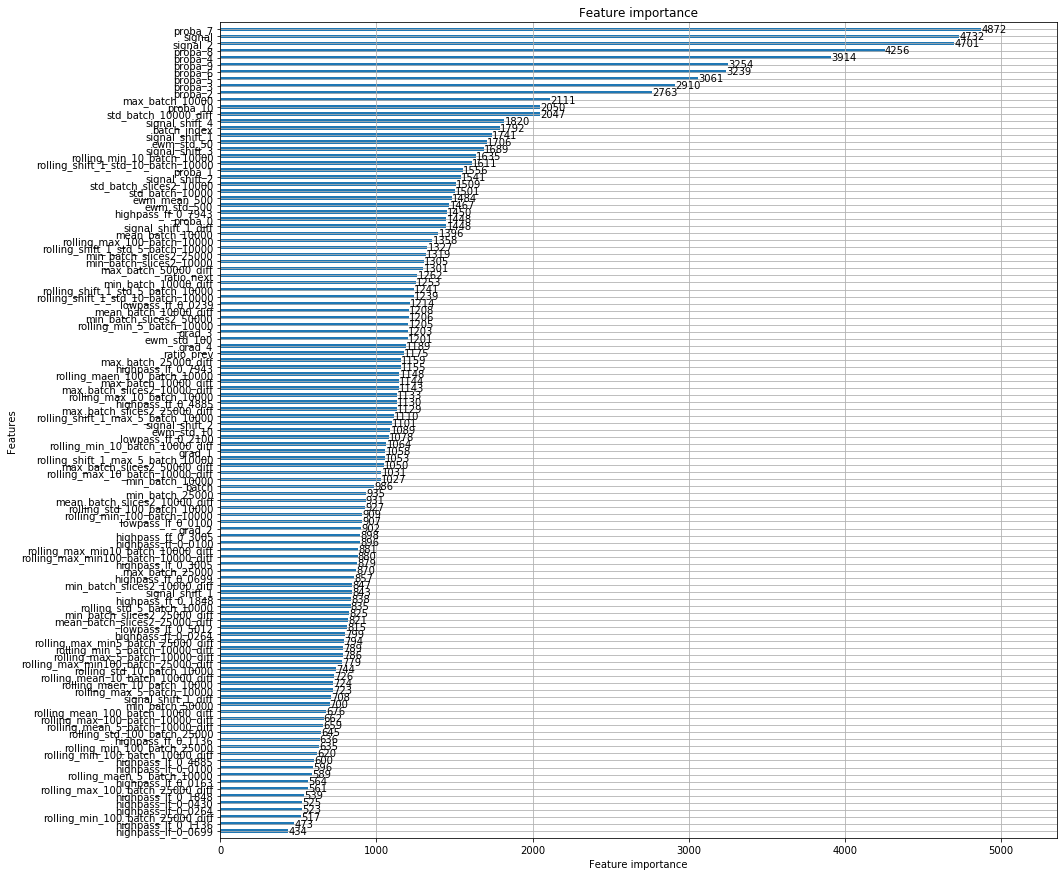

In [41]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
lgb.plot_importance(lgb_model.model,ax = axes,height = 0.5) #LGBmodel data stored in "model"
plt.show();plt.close()

In [42]:
#get importance data
importance = pd.DataFrame(index=features)
importance["importance"]=lgb_model.model.feature_importance()
importance.to_csv("feature_importance_new_feature_rev12.csv", index=True)

# Define Optimized Rounder

In [43]:
#ref:https://www.kaggle.com/artgor/eda-and-model-f1-optimization
import numpy as np
import scipy as sp
from functools import partial
from sklearn import metrics

class OptimizedRounderF1(object):
    """
    An optimizer for rounding thresholds
    to maximize f1 score
    """
    def __init__(self):
        self.coef_ = 0

    def _f1_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

        return -metrics.f1_score(y, X_p, average='macro')

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._f1_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

# Model Evaluation

In [44]:
#def pred_proc(pred):
#    pred = np.round(np.clip(pred, 0, 10))
#    return pred.astype(int)

In [45]:
#Hevy code. In kaggle submission, this code should be comment-out
y_train_pred=lgb_model.model.predict(train_df[features])#, num_iteration=lgb_model.model.best_iteration) #default =100
y_train_true=train_df["open_channels"]

In [46]:
#y_train_pred=pred_proc(y_train_pred)
#y_train_pred

In [47]:
optR = OptimizedRounderF1()
optR.fit(y_train_pred.reshape(-1,), y_train_true)
coefficients=optR.coefficients()
print(coefficients)

[0.51561752 1.52209417 2.51614986 3.45671739 4.46997703 5.4635206
 6.48371529 7.51043648 8.48506995 9.47533346]


In [48]:
opt_pred = optR.predict(y_train_pred.reshape(-1,), coefficients)
print('f1', metrics.f1_score(y_train_true, opt_pred, average = 'macro'))

f1 0.9422516182081975


In [49]:
# Showing Confusion Matrix
# Thanks to https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud
def plot_cm(y_train_true, y_train_pred, title):
    figsize=(14,14)
    y_train_pred = y_train_pred.astype(int)
    cm = confusion_matrix(y_train_true, y_train_pred, labels=np.unique(y_train_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_train_true), columns=np.unique(y_train_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

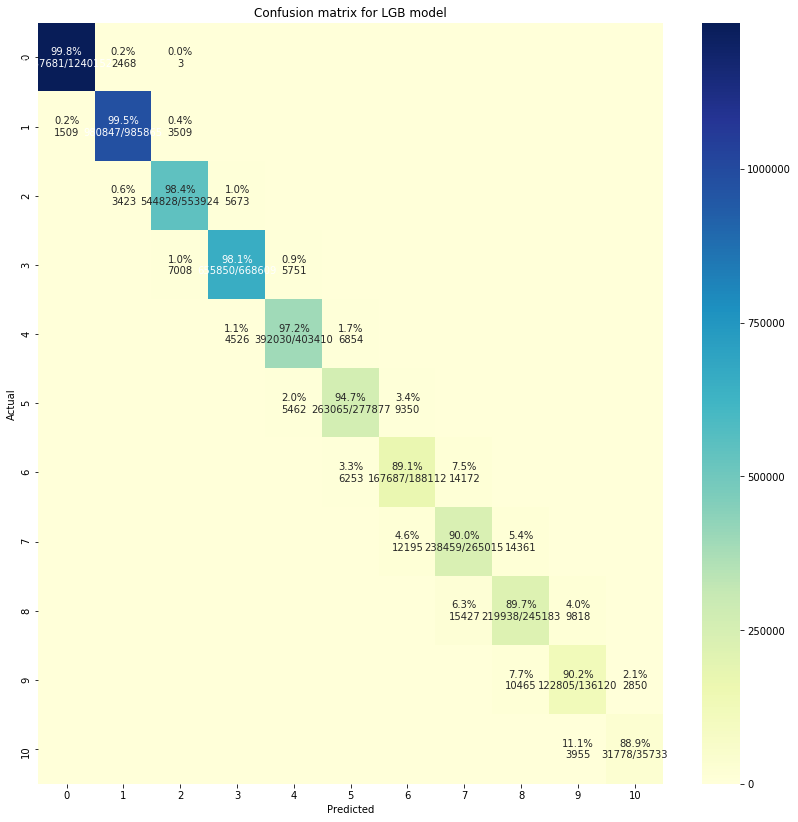

In [50]:
# Showing Confusion Matrix for LGB model
#plot_cm(y_train_true, y_train_pred, 'Confusion matrix for LGB model')
plot_cm(y_train_true, opt_pred, 'Confusion matrix for LGB model')

In [51]:
train = pd.read_csv(os.path.join(DATA_PATH, 'train_clean.csv'))
#devide dataset for each batch
train["signal_shift"]=train["signal"].shift(1).fillna(0)
train["y_pred"]=opt_pred
train.to_csv('lgb_clean_outlier_y_pred_rev12.csv', index=False, float_format='%.4f')

#devide each batch
train_1=train[:500000]
train_2=train[500000:1000000]
train_3=train[1000000:1500000]
train_4=train[1500000:2000000]
train_5=train[2000000:2500000]
train_6=train[2500000:3000000]
train_7=train[3000000:3500000]
train_8=train[3500000:4000000]
train_9=train[4000000:4500000]
train_10=train[4500000:5000000]

In [52]:
from sklearn.metrics import classification_report
target_names = ['0','1','2','3','4','5','6','7','8','9','10']
report = classification_report(train["open_channels"], train["y_pred"],target_names=target_names, digits= 4)
print(report)

              precision    recall  f1-score   support

           0     0.9988    0.9980    0.9984   1240152
           1     0.9940    0.9949    0.9945    985865
           2     0.9811    0.9836    0.9823    553924
           3     0.9847    0.9809    0.9828    668609
           4     0.9722    0.9718    0.9720    403410
           5     0.9525    0.9467    0.9496    277877
           6     0.8861    0.8914    0.8888    188112
           7     0.8896    0.8998    0.8947    265015
           8     0.8986    0.8970    0.8978    245183
           9     0.8992    0.9022    0.9007    136120
          10     0.9177    0.8893    0.9033     35733

    accuracy                         0.9710   5000000
   macro avg     0.9431    0.9414    0.9423   5000000
weighted avg     0.9711    0.9710    0.9710   5000000



# Predict test data

In [65]:
test_preds=lgb_model.y_pred

In [66]:
#test_preds=pred_proc(test_preds)

In [67]:
opt_test_preds = optR.predict(test_preds.reshape(-1,), coefficients)

Text(0.5, 1.0, 'Predictions distribution')

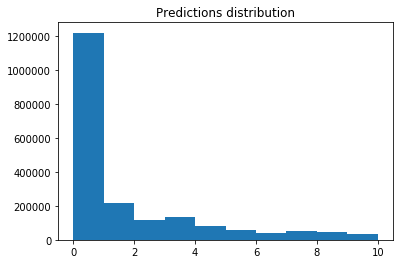

In [68]:
plt.hist(opt_test_preds);
plt.title('Predictions distribution')

In [69]:
submission_df['open_channels'] = opt_test_preds
submission_df.to_csv('submission_clean_outlier_rev12.csv', index=False, float_format='%.4f')

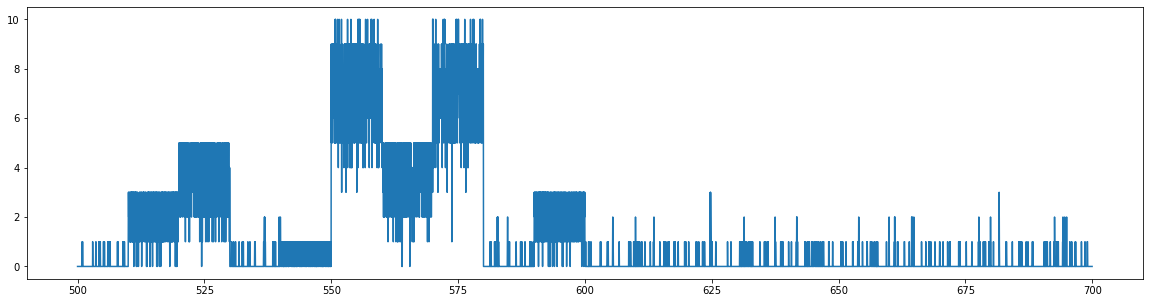

In [70]:
import matplotlib.pyplot as plt
res=200
plt.figure(figsize=(20,5))
plt.plot(submission_df.time[::res],submission_df.open_channels[::res])
plt.show()

# Validate Test Prediction

In [71]:
test = pd.read_csv(os.path.join(DATA_PATH, 'test_clean.csv'))
test["open_channels"]=submission_df["open_channels"]
test.head()

,time,signal,open_channels
0,500.0001,-2.649831,0
1,500.0002,-2.849463,0
2,500.0003,-2.860094,0
3,500.0004,-2.435126,0
4,500.0005,-2.615657,0


In [72]:
#devide dataset after 600.0000s
test_after=test[1000000:]
test_after.head()

,time,signal,open_channels
1000000,600.0001,-2.633631,0
1000001,600.0002,-2.858763,0
1000002,600.0003,-2.665994,0
1000003,600.0004,-2.663226,0
1000004,600.0005,-2.420957,0


In [73]:
test_after["signal_shift"]=test_after["signal"].shift(1).fillna(0)
test_after.head()

,time,signal,open_channels,signal_shift
1000000,600.0001,-2.633631,0,0.000000
1000001,600.0002,-2.858763,0,-2.633631
1000002,600.0003,-2.665994,0,-2.858763
1000003,600.0004,-2.663226,0,-2.665994
1000004,600.0005,-2.420957,0,-2.663226


No handles with labels found to put in legend.


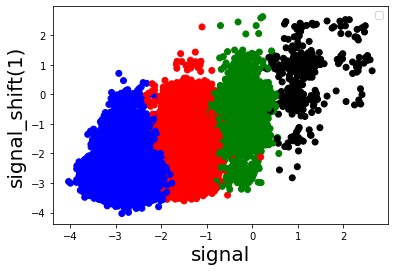

In [74]:
#Plot data
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

my_cmap = ListedColormap(['blue','red','green',"black"])
#label=["open_channel=0", "open_channel=1","open_channel=2","open_channel=3"]
plt.scatter(x=test_after["signal"], y=test_after["signal_shift"], c=test_after["open_channels"], cmap=my_cmap)
plt.xlabel("signal",fontsize=20)
plt.ylabel("signal_shift(1)", fontsize=20)
plt.legend()
plt.show()

In [75]:
test_after["open_channels"].value_counts()

0     916717
1      78164
2       4753
3        357
4          9
10         0
9          0
8          0
7          0
6          0
5          0
Name: open_channels, dtype: int64